In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
from transvae import analysis

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

This tutorial will demonstrate how to visualize and interpret model memory and how to evaluate model performance on a number of metrics. Full scripts for training models, generating samples and calculating attention weights are provided and instructions on how to use those scripts are included in the README. The functions demonstrated in this tutorial do not have pre-written high throughput scripts but can be used on larger input sizes if desired. 

# Model Reconstruction Performance

A set of metrics on reconstruction accuracy of the different models is presented below. Some parameters need to be selected:
<ul>
    <li>data size: int --how many samples from the data to laod
    <li>data selection: string  --training, testing, full_no_shuffle
    <li>model_src: string --path to model checkpoint
    <li>models : RNN, WAE, AAE, RNNAttn, TransVAE --model selectiong from listed
</ul>

In [5]:
data_selection = "full_no_shuffle"
model_src = "checkpointz//wae_amp//emb128_latent64//2000_wae-128_peptide.ckpt"
src = 'checkpointz//wae_amp//emb128_latent64//log_wae-128_peptide.txt' #src of the loss output file not the model ckpt!
model = WAE(load_fn=model_src)

save_dir= "model_analyses//"+model.name+"_latent_64" #each model will have its own directory
if not os.path.exists(save_dir):os.mkdir(save_dir) 
save_dir= save_dir+"//" #actually enter the folder that was created above

save_df = pd.DataFrame() #this will hold the number variables and save to CSV

gpu = False

if "full_no_shuffle" in data_selection:
    data = pd.read_csv('notebooks//example_data//peptide_combined_no_shuff.txt').to_numpy() 
elif "training" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_train.txt').to_numpy()
elif "testing" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_test.txt').to_numpy()
else:
    data = pd.read_csv('notebooks//example_data//train_test//.txt').to_numpy() 
data_1D = data[:5000,0] #gets rid of extra dimension
if gpu:
    data.cuda

WAE class init called /n
WAE class build_model called /n


G:\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


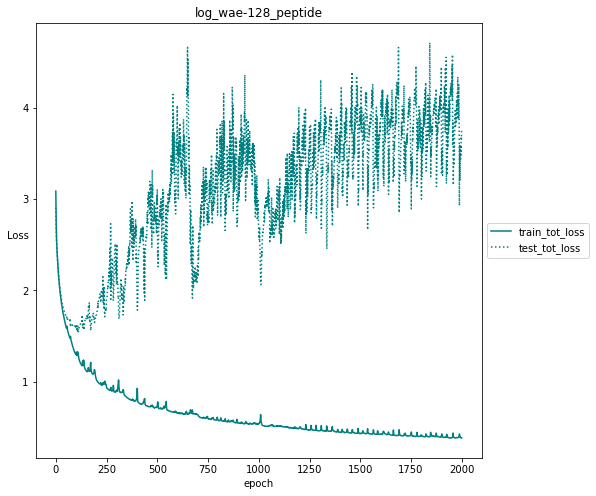

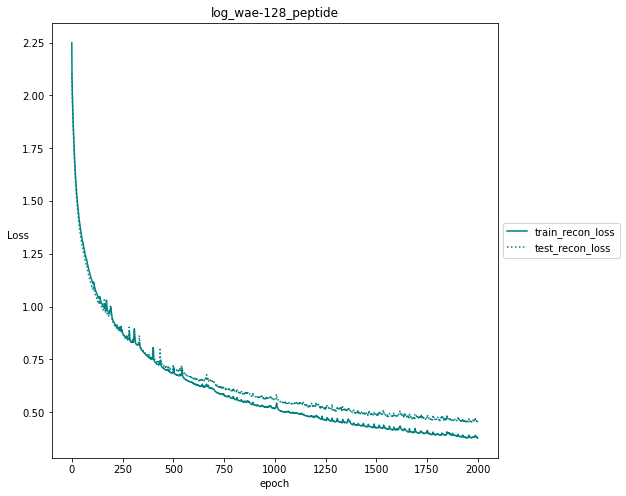

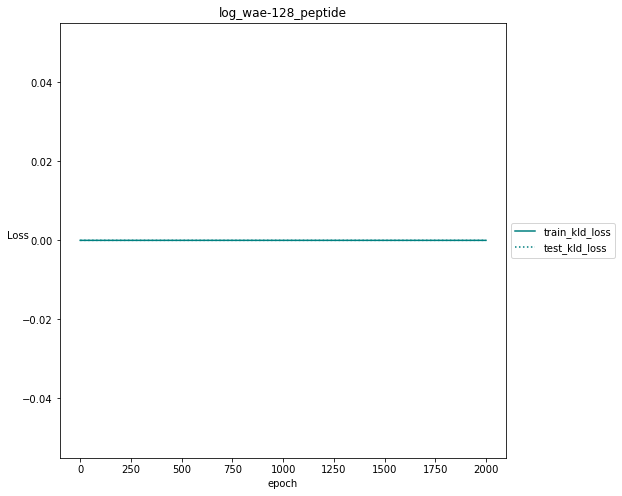

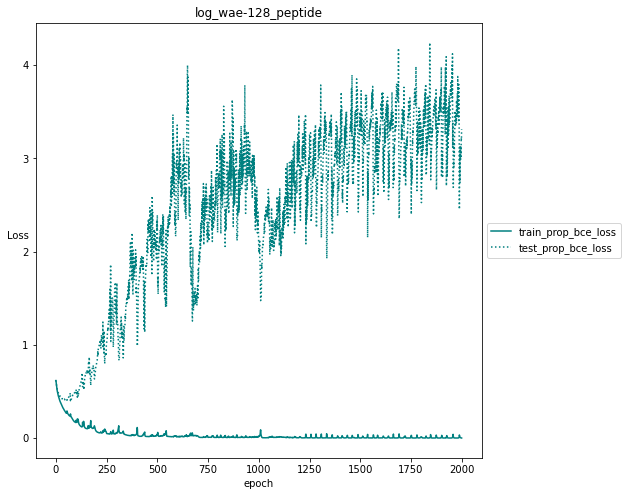

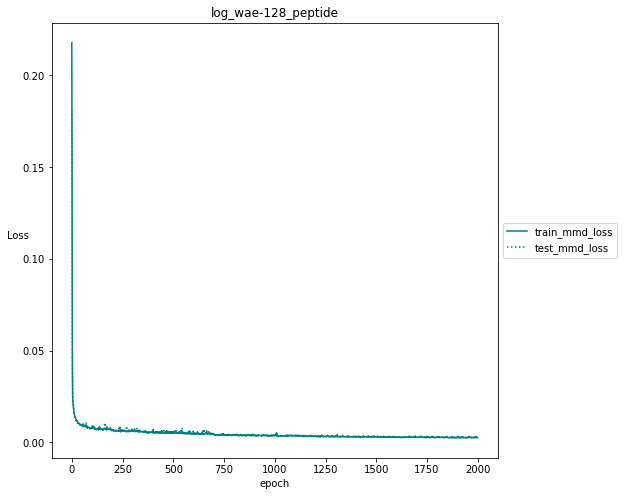

In [6]:
tot_loss = analysis.plot_loss_by_type(src,loss_types=['tot_loss'])
plt.savefig(save_dir+'tot_loss.png')
recon_loss = analysis.plot_loss_by_type(src,loss_types=['recon_loss'])
plt.savefig(save_dir+'recon_loss.png')
kld_loss = analysis.plot_loss_by_type(src,loss_types=['kld_loss'])
plt.savefig(save_dir+'kld_loss.png')
prob_bce_loss = analysis.plot_loss_by_type(src,loss_types=['prop_bce_loss'])
plt.savefig(save_dir+'prob_bce_loss.png')
if 'aae' in src:
    disc_loss = analysis.plot_loss_by_type(src,loss_types=['disc_loss'])
    plt.savefig(save_dir+'disc_loss.png')
if 'wae' in src:
    mmd_loss = analysis.plot_loss_by_type(src,loss_types=['mmd_loss'])
    plt.savefig(save_dir+'mmd_loss.png')

In [4]:
model.params['BATCH_SIZE'] = 200
reconstructed_seq, props = model.reconstruct(data[:200], log=False, return_mems=False)
for og_token, reconstructed_token in zip(data_1D, reconstructed_seq):
    print('{} <- Original'.format(og_token))
    print('{} <- Reconstruction'.format(reconstructed_token))
    print('\n')

rnn-128_peptide
cpu
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  10
decoding sequences of max length  125 current position:  20
decoding sequences of max length  125 current position:  30
decoding sequences of max length  125 current position:  40
decoding sequences of max length  125 current position:  50
decoding sequences of max length  125 current position:  60
decoding sequences of max length  125 current position:  70
decoding sequences of max length  125 current position:  80
decoding sequences of max length  125 current position:  90
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  110
decoding sequences of max length  125 current position:  120
GIGAVLKVLTTGLPALISWIKRKRQQ <- Original
GIGAVLKVLTTGLPALISWIKRKRQQ <- Reconstruction


GIGKFLHSAKKFGKAFVGEIMNS <- Original
GIGKFLHSAKKFGKAFVGEIMNS <- Reconstruction


ILPWKWPWWPWRR <- Original
ILPWKW

In [5]:
save_df['reconstructions'] = reconstructed_seq #placing the saves on a line separate from the ops allows for editing
save_df['predicted properties'] = [prop.item() for prop in props]

<ul>MCC info:
    <li>+1 represents a perfect prediction
    <li>0 no better than random prediction
    <li>−1 indicates total disagreement between prediction and observation.
</ul>

In [6]:
true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
true_props = true_props_data[0:200,0]
prop_acc ,MCC = calc_property_accuracies(props,true_props, MCC=True)

property accuracy : 191 / 200 = 0.955
MCC:  Data error Division by zero


In [7]:
save_df['property prediction accuracy'] = prop_acc
save_df['MCC'] = MCC

Token accuracies are accuracies per token, 
<ul>
    <li>sequence accuracies are accuracies per sequence
    <li>token accuracies are accuracies for each token averaged over all tokens in input dataset
    <li>position accuracies are per sequence position

In [8]:
# First we tokenize the input and reconstructed smiles
input_sequences = []
for seq in data_1D:
    input_sequences.append(peptide_tokenizer(seq))
output_sequences = []
for seq in reconstructed_seq:
    output_sequences.append(peptide_tokenizer(seq))

In [9]:
seq_accs, token_accs, position_accs = calc_reconstruction_accuracies(input_sequences, output_sequences)

G:\GitHub\MSCSAM_TBD\main_model\transvae\tvae_util.py:210: RuntimeWarning: invalid value encountered in double_scalars
  position_acc.append(position_accs[0,i] / position_accs[1,i])


In [10]:
seq_accs, token_accs

(0.77, 0.8817453250222618)

In [11]:
save_df['sequence accuracy'] = seq_accs
save_df['token accuracy'] = token_accs

Plotting the accuracy on token position

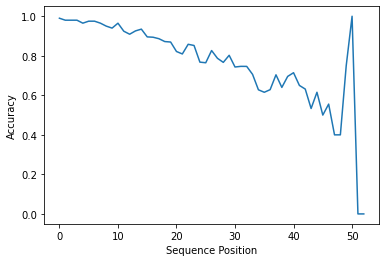

In [12]:
plt.plot(position_accs)
plt.xlabel('Sequence Position')
plt.ylabel('Accuracy')
plt.savefig(save_dir+'token_position_accuracy.png')
plt.show()

# Visualizing Model Memory

The memory of a model is analogous to the probability distribution of molecular embeddings that it has learned during training. A single molecular embedding is the size 128 vector at the center of the variational bottleneck. Each model has a built-in method for calculating and returning the model memory for a set of input structures, `calc_mems()`. ***(note - we plot the mean vector rather than the reparameterized vector so we can identify and analyze the meaningful latent dimensions)***

In [13]:
if model.model_type =='aae':
    mems, _, _ = model.calc_mems(data[:], log=False, save=False) 
elif model.model_type == 'wae':
    mems, _, _ = model.calc_mems(data[:], log=False, save=False) 
else:
    mems, mus, logvars = model.calc_mems(data[:], log=False, save=False) 

rnn-128_peptide


Shannon information entropy

In [14]:
vae_entropy_mems  = calc_entropy(mems)
vae_entropy_mus = calc_entropy(mus)
vae_entropy_logvars = calc_entropy(logvars)

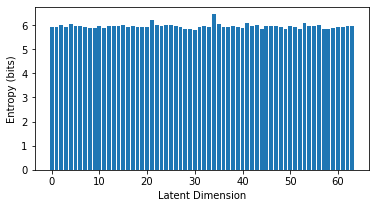

In [15]:
fig = plt.figure(figsize=(6,3))

plt.bar(range(len(vae_entropy_mems)), vae_entropy_mems)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.savefig(save_dir+'mem_entropy')

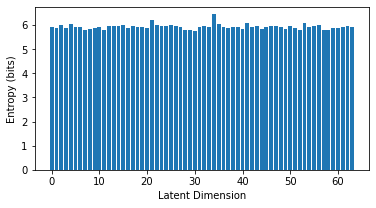

In [16]:
fig = plt.figure(figsize=(6,3))

plt.bar(range(len(vae_entropy_mus)), vae_entropy_mus)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.savefig(save_dir+'mu_entropy')

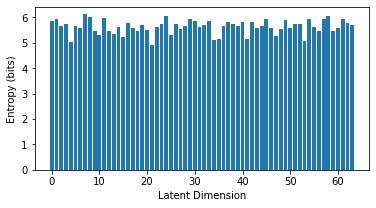

In [17]:
fig = plt.figure(figsize=(6,3))

plt.bar(range(len(vae_entropy_logvars)), vae_entropy_logvars)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.savefig(save_dir+'logvar_entropy')

We can see that some dimensions have significantly more information contained across the 25 samples than others and they correspond with the selective memory visualization shown above. We can sum the entropy of all dimensions to find the full model entropy. Again, note that we would need a larger sample size to converge the model entropy.

In [18]:
total_entropy_mems = np.sum(vae_entropy_mems)
print('The model memories contain {} nats of information'.format(round(total_entropy_mems, 2)))
total_entropy_mus = np.sum(vae_entropy_mus)
print('The model means contain {} nats of information'.format(round(total_entropy_mus, 2)))
total_entropy_logvars = np.nansum(vae_entropy_logvars)
print('The model logvar contain {} nats of information'.format(round(total_entropy_logvars, 2)))
save_df['mem entropy']= total_entropy_mems
save_df['mu entropy']= total_entropy_mus
save_df['logvar entropy']= total_entropy_logvars

The model memories contain 380.46 nats of information
The model means contain 379.22 nats of information
The model logvar contain 360.67 nats of information


<h4>Evaluate the trustworthiness of the mapping from raw input data to latent space manifold

In [ ]:
flattened_data = data[:,0]
    max_len = 126
    char_dict = model.params['CHAR_DICT']
    input_sequences = []
    for seq in flattened_data:
        tokenized = (peptide_tokenizer(seq))
        input_sequences.append(encode_seq(tokenized, max_len, char_dict))
    raw_input=input_sequences

raw_trust = trustworthiness(mems,pca_batch)

In [19]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import trustworthiness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import plotly.express as px

subsample_start=0
subsample_length=mems.shape[0] #this may change depending on batch size

pca = PCA(n_components=4)

#only need to perform PCA once then can color code based on either length or function
pca_batch =pca.fit_transform(X=mems[:])

#(for length based coloring): record all peptide lengths iterating through input
pep_lengths = []
for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    pep_lengths.append( len(pep[0]) )
fig = px.scatter_matrix(pca_batch, color= pep_lengths, opacity=0.8)
fig.write_image(save_dir+'pca_length.png', width=1200, height=800)

#(for function based coloring): pull function from csv with peptide functions
s_to_f =pd.read_csv("data//peptides//amp_function//sequence_function_link_std_only.csv")    
function = s_to_f["Antimicrobial"][subsample_start:(subsample_start+subsample_length)]
fig = px.scatter_matrix(pca_batch, color= [str(itm) for itm in function], opacity=0.8)
fig.write_image(save_dir+'pca_function.png', width=1200, height=800)

mem_func_sil = metrics.silhouette_score(mems, function, metric='euclidean')
print('Silhoutte score of latent memory & function: ',mem_func_sil)
save_df['latent_to_func_sil'] = mem_func_sil


XY = [i for i in zip(pca_batch[:,0], pca_batch[:,1])]
pca_func_sil = metrics.silhouette_score(XY, function, metric='euclidean')
print('Silhoutte score of PCA latent memory & function: ',pca_func_sil)
save_df['PCA_to_func_sil']= pca_func_sil

pca_trust = trustworthiness(mems,pca_batch)
print('Trustworthiness mems to PCA ', trust)

Silhoutte score of latent memory & function:  0.018695481
Silhoutte score of PCA latent memory & function:  0.016790267


In [20]:
save_df.to_csv(save_dir+"saved_info.csv", index=False)